In [114]:
import drawsvg as draw
import itertools

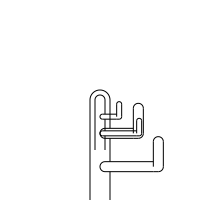

In [171]:
class Arm():
    
    def __init__(self, intersect_height, direction, width, height, thickness):
        self.intersect_height = intersect_height
        self.direction = direction
        self.width = width
        self.height = height
        self.thickness = thickness

def Pipe(x, y, width, height, is_vertical=False, **kwargs):
    pipe = draw.Group()
    if is_vertical:
        pipe.append(draw.Line(x, y, x, y+height, **kwargs))
        pipe.append(draw.Line(x+width, y, x+width, y+height, **kwargs))
    else:
        pipe.append(draw.Line(x, y, x+width, y, **kwargs))
        pipe.append(draw.Line(x, y+height, x+width, y+height, **kwargs))
    return pipe

def Cap(x, y, radius, direction="top", **kwargs):
    cap = draw.Path(**kwargs)
    if direction == "top":
        cap = cap.M(
            x=x-radius,
            y=y,
        ).A(
            rx=radius, 
            ry=radius,
            rot=0,
            large_arc=0,
            sweep=1,
            ex=x+radius,
            ey=y,
        )
    if direction == "left":
        cap = cap.M(
            x=x,
            y=y+radius,
        ).A(
            rx=radius, 
            ry=radius,
            rot=0,
            large_arc=0,
            sweep=1,
            ex=x,
            ey=y-radius,
        )
    if direction == "right":
        cap = cap.M(
            x=x,
            y=y-radius,
        ).A(
            rx=radius, 
            ry=radius,
            rot=0,
            large_arc=0,
            sweep=1,
            ex=x,
            ey=y+radius,
        )
    if direction == "right-elbow":
        cap = cap.M(
            x=x+radius,
            y=y,
        ).A(
            rx=radius, 
            ry=radius,
            rot=0,
            large_arc=0,
            sweep=1,
            ex=x,
            ey=y+radius,
        )
        
    return cap

class Cactus():
    
    def __init__(self, x, y, height, thickness):
        self.x = x
        self.y = y
        self.height = height
        self.arms = []
        self.thickness = thickness
        
    def add_arm(self, intersect_height, direction, width, height, thickness):
        a = Arm(intersect_height, direction, width, height, thickness)
        self.arms.append(a)
        
    def draw_arm(self, drawing, a, **kwargs):
        arm_base_y = self.y + a.intersect_height
        arm_base_x = self.x + a.thickness/2
        drawing.append(
            Cap(
                arm_base_x, 
                arm_base_y, 
                a.thickness/2, 
                "left",
                **kwargs))
        drawing.append(
            Pipe(
                x=arm_base_x, 
                y=arm_base_y-a.thickness/2.0, 
                width=a.width-a.thickness/2.0,
                height=a.thickness, 
                is_vertical=False,
                **kwargs))
        drawing.append(
            draw.Line(
                sx=arm_base_x+a.width-a.thickness/2.0, 
                sy=arm_base_y+a.thickness/2.0, 
                ex=arm_base_x+a.width,
                ey=arm_base_y+a.thickness/2.0, 
                **kwargs))
        drawing.append(
            Cap(
                arm_base_x+a.width, 
                arm_base_y, 
                a.thickness/2, 
                "right-elbow", 
                **kwargs))
        drawing.append(
            Pipe(
                x=arm_base_x+a.width-a.thickness/2.0, 
                y=arm_base_y-a.height, 
                width=a.thickness,
                height=a.height, 
                is_vertical=True,
                **kwargs))
        drawing.append(
            Cap(
                arm_base_x+a.width, 
                arm_base_y-a.height, 
                a.thickness/2, 
                "top", 
                **kwargs))
        
    def get_line_points(self, points):
        """
        takes flattened array of points
        returns pairs of points ((start_x, start_y),(end_x, end_y))
        """
        return list(itertools.pairwise(
            list(itertools.pairwise(points))[::2]
        ))
        
    def draw_trunk(self, drawing, front_arms, **kwargs):
        left_line = [
            self.x-self.thickness/2, 
            self.y,
            self.x-self.thickness/2, 
            self.y+self.height,
        ]
        right_line = [
            self.x+self.thickness/2, 
            self.y,
            self.x+self.thickness/2, 
            self.y+self.height,
        ]
        # left_arms
        right_arms = front_arms
        
        for line in self.get_line_points(left_line):
            drawing.append(draw.Line(*line[0], *line[1], **kwargs))
            
        for arm in right_arms[::-1]:
            right_line.insert(2,self.x+self.thickness/2)
            right_line.insert(3,self.y+arm.intersect_height-arm.thickness/2)
            right_line.insert(4,self.x+self.thickness/2)
            right_line.insert(5,self.y+arm.intersect_height+arm.thickness/2)
            
        for i, line in enumerate(self.get_line_points(right_line)):
            if i%2==0:
                drawing.append(draw.Line(*line[0], *line[1], **kwargs))
            
        drawing.append(Cap(
            self.x, 
            self.y, 
            self.thickness/2, 
            direction="top", 
            **kwargs))
    
    def draw(self, drawing, **kwargs):
        front_arms = []
        back_arms = []
        for a in self.arms:
            if a.direction > 0:
                front_arms.append(a)
            else:
                back_arms.append(a)
        for a in front_arms:
            self.draw_arm(drawing, a, **kwargs)
        
        self.draw_trunk(drawing, front_arms, **kwargs)
            
            
drawing = draw.Drawing(200, 200, origin='top-left', displayInline=False)

line_config = dict(
    stroke_width=1,
    stroke='black',
    stroke_opacity=1.0,
    fill_opacity=0.0
)

c = Cactus(
    x=drawing.width/2, 
    y=drawing.height-100,
    height=100, 
    thickness=20)
c.add_arm(
    intersect_height=c.height/3, 
    direction=1, 
    width=c.height/3, 
    height=c.height/4, 
    thickness=c.thickness/2)
c.add_arm(
    intersect_height=c.height*2/3, 
    direction=1, 
    width=c.height/3+20, 
    height=c.height/4, 
    thickness=c.thickness/2)

c.draw(drawing, **line_config)

c = Cactus(
    x=drawing.width/2, 
    y=drawing.height-100,
    height=50, 
    thickness=10)
c.add_arm(
    intersect_height=c.height/3, 
    direction=1, 
    width=c.height/3, 
    height=c.height/4, 
    thickness=c.thickness/2)
c.add_arm(
    intersect_height=c.height*2/3, 
    direction=1, 
    width=c.height/3+20, 
    height=c.height/4, 
    thickness=c.thickness/2)

c.draw(drawing, **line_config)

# Display in Jupyter notebook
drawing.rasterize()  # Display as PNG
drawing  # Display as SVG